# Camera Calibration

We'll take the images found in the camera_cal directory and obtain the calibration parameters for the camera in use. Our chessboard size is 9x6.

In [38]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points
nx = 9
ny = 6

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

folder = "./camera_cal/"
pickle_file = folder + "camera_points.pickle"
if os.path.exists(pickle_file):
    # load pickle
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        objpoints = pickle_data["objpoints"]
        imgpoints = pickle_data["imgpoints"]
        del pickle_data
else:
    for fname in os.listdir(folder):
        img = cv2.imread(folder + fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        shape = (img.shape[0:2][1], img.shape[0:2][0])

        # If found, draw corners
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    # save pickle
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    "objpoints": objpoints,
                    "imgpoints": imgpoints,
                },
                pfile, pickle.DEFAULT_PROTOCOL)
    except Exception as e:
        print("Unable to save data to", pickle_file, ":", e)
        raise


[[  1.24027474e+00   3.01579242e-01  -1.55474403e+02]
 [ -1.48946293e-02   1.31778590e+00   2.36231326e+01]
 [ -4.21588173e-05   5.08014068e-04   1.00000000e+00]]


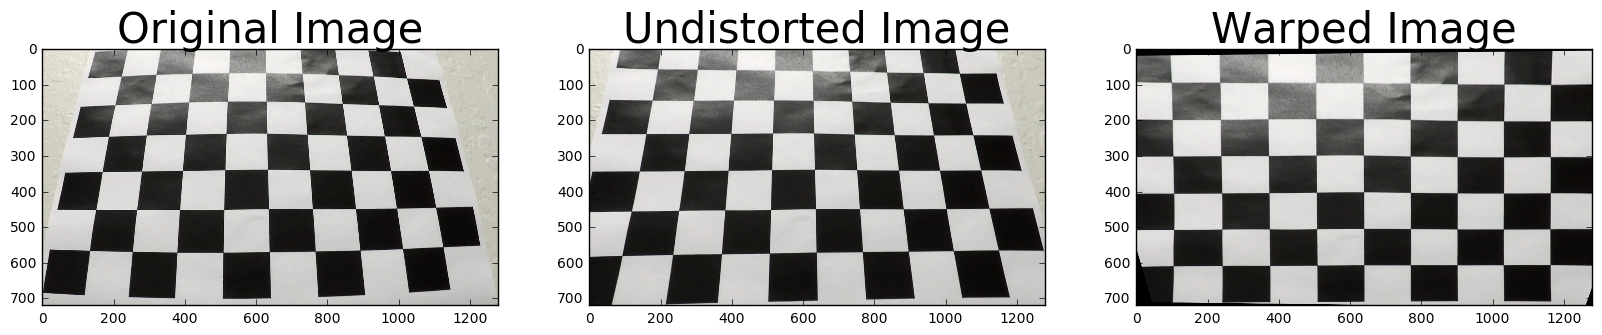

In [46]:

# Test the calibration numbers
def extract_edge_corners(corners, nx, ny):
    top_left = 0
    top_right = top_left + (nx -1)
    bottom_left = (ny - 1) * nx
    bottom_right = bottom_left + (nx - 1)
    return np.float32([
        corners[top_left][0],
        corners[top_right][0],
        corners[bottom_right][0],
        corners[bottom_left][0]
        ])

def create_expected_edge_corners(shape, nx, ny):
    max_x = shape[0]
    max_y = shape[1]
    segment_x = 1 / nx
    segment_y = 1 / ny
    return np.float32([
        [max_x * segment_x, max_y * segment_y],
        [max_x * (segment_x * (nx - 1)), max_y * segment_y],
        [max_x * (segment_x * (nx - 1)), max_y * (segment_y * (ny - 1))],
        [max_x * segment_x, max_y * (segment_y * (ny - 1))]
        ])

img = cv2.imread(folder + "calibration3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size ,None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
shape = (img.shape[0:2][1], img.shape[0:2][0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret:
    src = extract_edge_corners(corners, nx, ny)
    dst = create_expected_edge_corners(shape, nx, ny)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, shape, flags=cv2.INTER_LINEAR)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    ax3.imshow(warped)
    ax3.set_title('Warped Image', fontsize=30)

print(M)

# Pipeline (test images)

Let's test test the camera correction values on the test images.

Test image


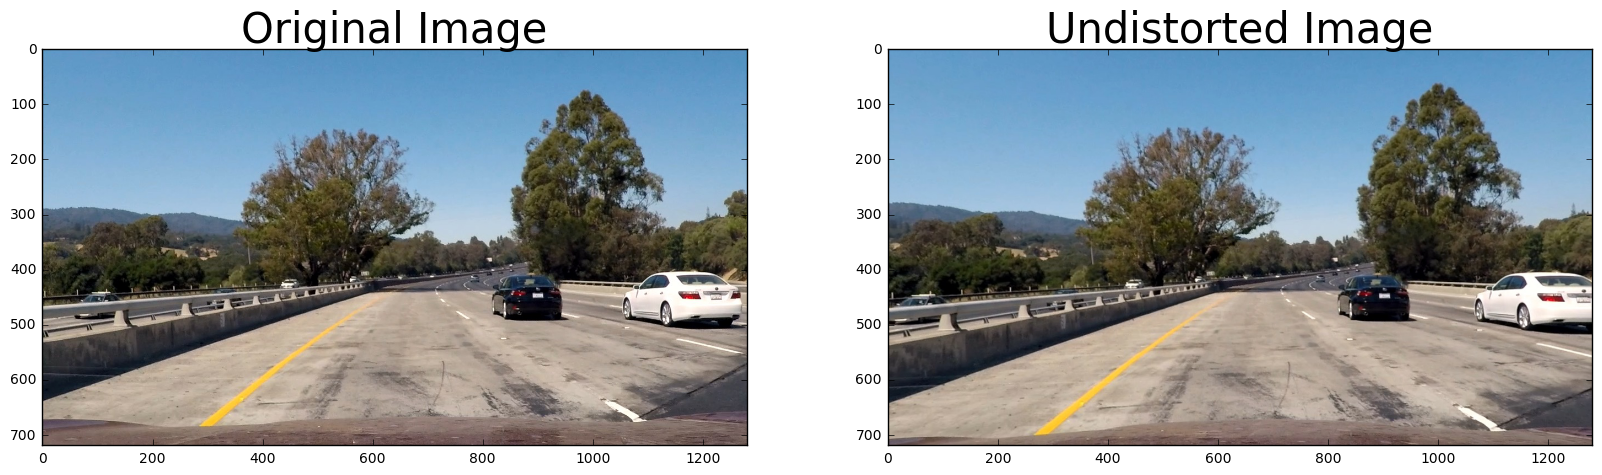

In [47]:
def camera_undistort(img):
    size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size ,None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
print("Test image")

Test image


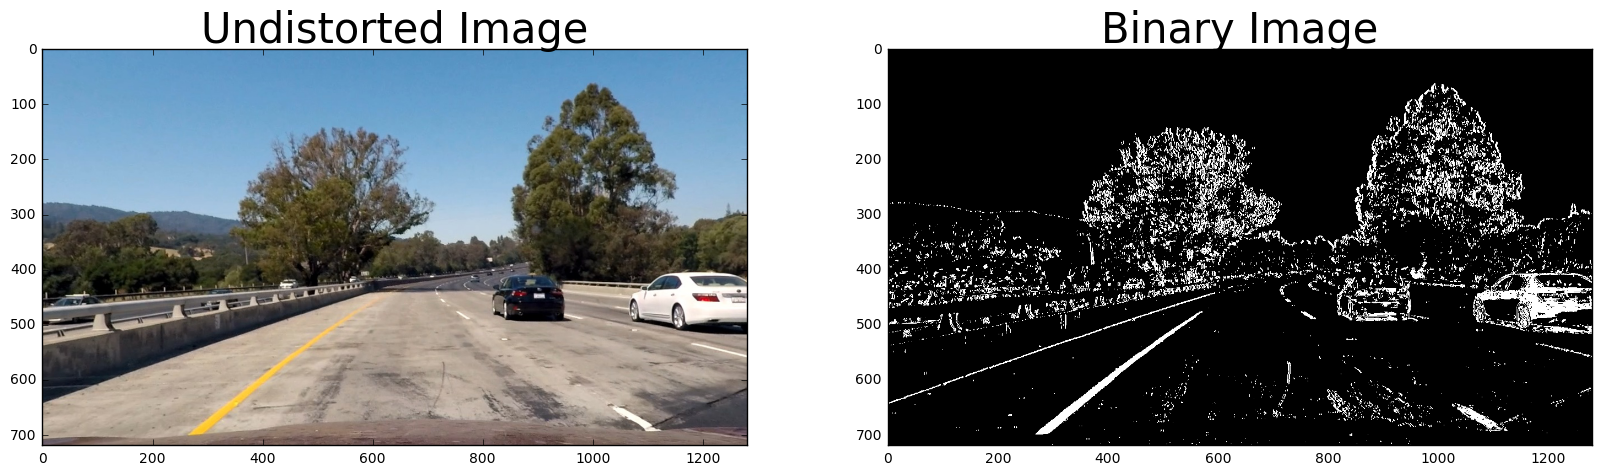

In [58]:
def thresholded_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x on L channel to obtain x gradient
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine
    binary = np.zeros_like(sxbinary)
    binary[(sxbinary == 1) | (s_binary == 1)] = 1
    return binary

img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = thresholded_binary(undist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
print("Test image")

Test image, straight lines


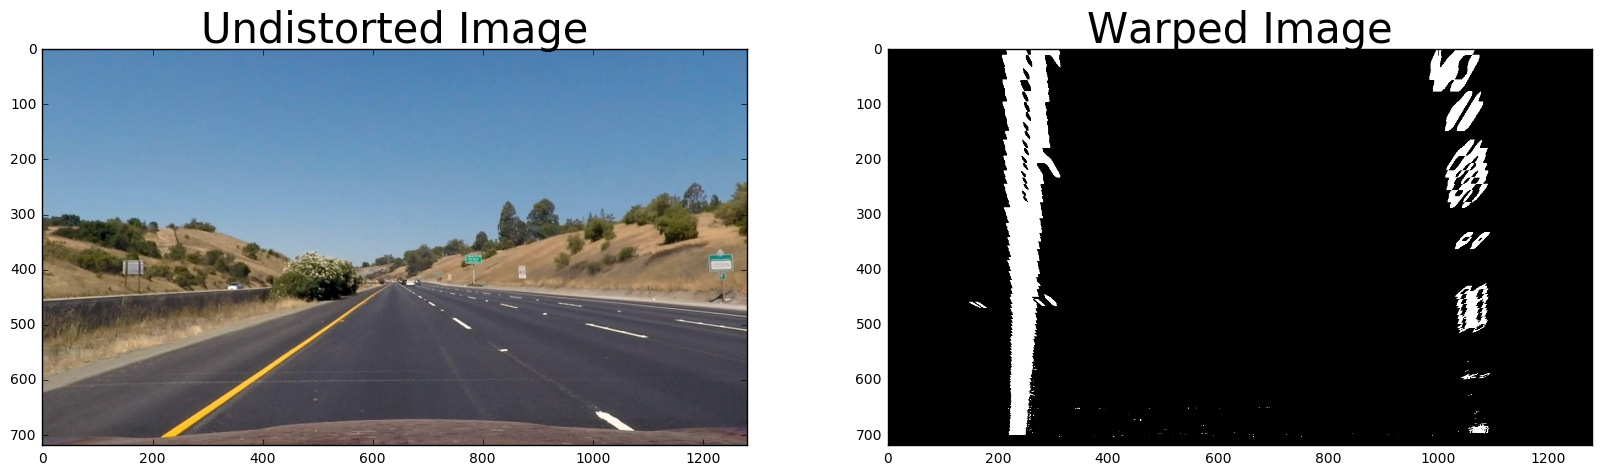

In [71]:
def perspective_transform(img):
    src = np.float32([
            (590, 450),
            (690, 450),
            (1080, 700),
            (200, 700)
        ])
    dst = np.float32([
            (200, 0),
            (1080, 0),
            (1080, 700),
            (200, 700)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)
    

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = thresholded_binary(undist)
warped = perspective_transform(binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
print("Test image, straight lines")

Test image, straight lines


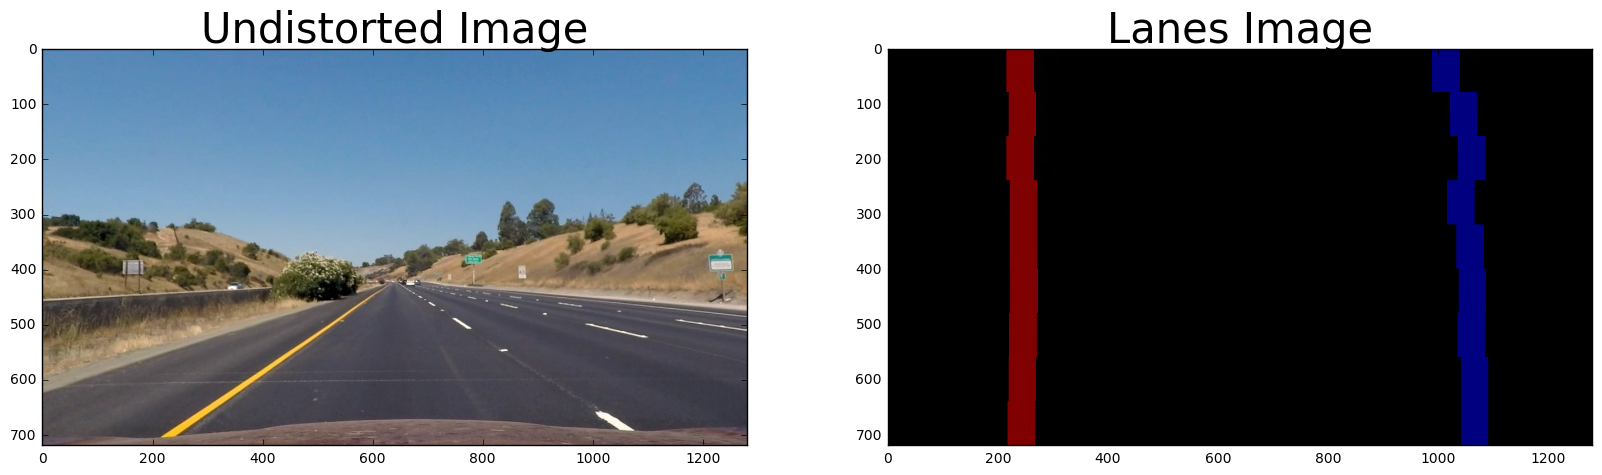

In [77]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def lane_line_pixels(img):
    shape = (img.shape[0:2][1], img.shape[0:2][0])
    window_width = 50 
    window_height = int(shape[1] / 9)
    margin = 100 # How much to slide left and right for searching
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel 
        template = np.array(cv2.merge((l_points,zero_channel,r_points)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        return cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    return img

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = camera_undistort(img)
binary = thresholded_binary(undist)
warped = perspective_transform(binary)
lanes = lane_line_pixels(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(lanes)
ax2.set_title('Lanes Image', fontsize=30)
print("Test image, straight lines")